# cdse-client v0.3.0 - End-to-End Test Notebook

Complete test suite for all library features: search, download, export, geometry utilities, and quicklooks.

**Requirements**: Create a `.env` file in the project root with:
```
CDSE_CLIENT_ID=your-client-id
CDSE_CLIENT_SECRET=your-client-secret
```

## 1. Setup & Installation

In [5]:
# Install cdse-client with all optional dependencies
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
%pip install -q -e "{project_root}[all]" python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Load credentials from .env file
import os
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables
load_dotenv(Path.cwd().parent / '.env')

CLIENT_ID = os.environ.get('CDSE_CLIENT_ID', '')
CLIENT_SECRET = os.environ.get('CDSE_CLIENT_SECRET', '')

# Setup directories
OUTPUT_DIR = Path('./data/downloads')
QUICKLOOK_DIR = Path('./data/quicklooks')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
QUICKLOOK_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Credentials: {'OK' if CLIENT_ID else 'MISSING - set CDSE_CLIENT_ID'}")
print(f"✓ Download dir: {OUTPUT_DIR}")
print(f"✓ Quicklook dir: {QUICKLOOK_DIR}")

✓ Credentials: OK
✓ Download dir: data\downloads
✓ Quicklook dir: data\quicklooks


In [7]:
# Initialize the client
import cdse
from cdse import CDSEClient

print(f"cdse-client v{cdse.__version__}")

client = CDSEClient(CLIENT_ID, CLIENT_SECRET, str(OUTPUT_DIR))
print("✓ Client initialized successfully")

cdse-client v0.3.0
✓ Client initialized successfully


## 2. Search Products

Test various search methods: bbox, point, name, city.

In [8]:
BBOX = [9.10, 45.40, 9.28, 45.52]
products = client.search(bbox=BBOX, start_date='2025-06-01', end_date='2025-06-30', collection='sentinel-2-l2a', cloud_cover_max=20, limit=5)
print(f'Found {len(products)} products')
for p in products:
    print(f'  {p.name} - {p.cloud_cover:.1f}%')

Found 2 products
  S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE - 9.9%
  S2B_MSIL2A_20250619T101559_N0511_R065_T32TNR_20250619T132744.SAFE - 6.6%


In [9]:
# Search by geographic point (Milan center with buffer)
point_products = client.search_by_point(
    lon=9.19, 
    lat=45.46, 
    buffer_km=10,
    start_date='2025-06-01', 
    end_date='2025-06-30',
    collection='sentinel-2-l2a',
    cloud_cover_max=30,
    limit=3
)
print(f"✓ Point search: {len(point_products)} products")

✓ Point search: 1 products


In [10]:
# Search by product name (if we have products)
if products:
    test_name = products[0].name
    found = client.search_by_name(test_name)
    print(f"✓ Name search: {'Found' if found else 'Not found'} - {test_name[:40]}...")

✓ Name search: Found - S2A_MSIL2A_20250626T101701_N0511_R065_T3...


## 2b. Search by City (geocoding + predefined fallback)

This tests the city-based search helpers. It supports:
- **Predefined bbox** (no extra dependency, no external geocoding request)
- **Geocoding via Nominatim** (requires `cdse-client[geo]` and a network request)

In [11]:
# City search using predefined bounding boxes (no geopy required)
CITY = "milano"  # try also: roma, torino, paris, london, berlin

try:
    city_products_predef = client.search_by_city(
        city_name=CITY,
        start_date='2025-06-01',
        end_date='2025-06-30',
        collection='sentinel-2-l2a',
        cloud_cover_max=30,
        limit=3,
        use_predefined=True,
    )
    print(f"✓ City search (predefined bbox): {len(city_products_predef)} products for '{CITY}'")
except Exception as e:
    print(f"⚠ City search (predefined bbox) failed: {e}")

✓ City search (predefined bbox): 1 products for 'milano'


In [31]:
# City search using live geocoding (requires geopy + network)
CITY_QUERY = "Milano, Italia"

try:
    city_products_geo = client.search_by_city(
        city_name=CITY_QUERY,
        start_date='2025-06-01',
        end_date='2025-06-30',
        buffer_km=15,
        collection='sentinel-2-l2a',
        cloud_cover_max=30,
        limit=3,
        use_predefined=False,
    )
    print(f"✓ City search (geocoding): {len(city_products_geo)} products for '{CITY_QUERY}'")
except ImportError as e:
    print(f"⚠ geopy not installed: {e}")
except Exception as e:
    # Network calls to Nominatim can occasionally timeout or be rate-limited.
    print(f"⚠ City search (geocoding) failed: {e}")
    print("  Falling back to predefined bbox (offline/no network).")
    try:
        city_products_fallback = client.search_by_city(
            city_name=CITY,
            start_date='2025-06-01',
            end_date='2025-06-30',
            collection='sentinel-2-l2a',
            cloud_cover_max=30,
            limit=3,
            use_predefined=True,
        )
        print(f"✓ City search (fallback predefined): {len(city_products_fallback)} products for '{CITY}'")
    except Exception as e2:
        print(f"⚠ City search fallback failed: {e2}")

✓ City search (geocoding): 1 products for 'Milano, Italia'


In [13]:
# Geocoding utilities (direct usage)
from cdse.geocoding import get_predefined_bbox

bbox_predef = get_predefined_bbox(CITY)
print(f"Predefined bbox for '{CITY}': {bbox_predef}")

Predefined bbox for 'milano': (9.04, 45.386, 9.278, 45.536)


## 2c. Collections (STAC)

List available collections from the CDSE catalog.

In [14]:
collections = client.get_collections()
print(f"✓ Collections returned: {len(collections)}")
for k in sorted(list(collections.keys()))[:15]:
    print(f"  - {k}: {collections[k]}")

✓ Collections returned: 6
  - sentinel-1-grd: Sentinel-1 GRD
  - sentinel-2-l1c: Sentinel-2 L1C
  - sentinel-2-l2a: Sentinel-2 L2A
  - sentinel-3-olci: Sentinel-3 OLCI
  - sentinel-3-slstr: Sentinel-3 SLSTR
  - sentinel-5p-l2: Sentinel-5P L2


## 2d. Search by UUID (product id)

This validates `search_by_id()` using a UUID from the search results.

In [15]:
# NOTE: STAC search results often use the product *name* as `Product.id` (not the OData UUID).
# To test UUID lookup, first resolve an OData Product via search_by_name(), then call search_by_id().
if products:
    stac_name = products[0].name
    candidates = [stac_name]
    if not stac_name.endswith(".SAFE") and not stac_name.endswith(".SAFE.zip"):
        candidates.insert(0, f"{stac_name}.SAFE")

    odata_product = None
    for nm in candidates:
        odata_product = client.search_by_name(nm, exact=True)
        if odata_product:
            break

    if not odata_product:
        print("⚠ Could not resolve OData product by name; cannot test UUID lookup.")
    else:
        uuid = odata_product.id
        by_uuid = client.search_by_id(uuid)
        print(f"✓ Resolved OData UUID: {uuid}")
        print(f"✓ search_by_id: {'Found' if by_uuid else 'Not found'}")
        if by_uuid:
            print(f"  uuid matches: {by_uuid.id == uuid}")
            print(f"  name: {by_uuid.name}")

✓ Resolved OData UUID: 8f19b0da-80fe-482a-a85a-4288d9bf3c45
✓ search_by_id: Found
  uuid matches: True
  name: S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE


## 3. Data Export (sentinelsat compatible)

Test DataFrame, GeoJSON, and GeoDataFrame conversion.

In [16]:
# Convert to DataFrame (requires pandas)
df = client.to_dataframe(products)

print(f"✓ DataFrame: {len(df)} rows, {len(df.columns)} columns")
print(f"  Columns: {list(df.columns)}")

# Sort by cloud cover
df_sorted = df.sort_values('cloud_cover')
print(f"\n  Lowest cloud: {df_sorted.iloc[0]['name'][:40]}... ({df_sorted.iloc[0]['cloud_cover']:.1f}%)")

# Display the DataFrame
df[['name', 'datetime', 'cloud_cover', 'platform']]

✓ DataFrame: 2 rows, 15 columns
  Columns: ['name', 'collection', 'datetime', 'cloud_cover', 'platform', 'instrument', 'tile_id', 'orbit_number', 'processing_level', 'size', 'size_mb', 'bbox_min_lon', 'bbox_min_lat', 'bbox_max_lon', 'bbox_max_lat']

  Lowest cloud: S2B_MSIL2A_20250619T101559_N0511_R065_T3... (6.6%)


,name,datetime,cloud_cover,platform
id,,,,
S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE,S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_2...,2025-06-26 10:28:29.918000+00:00,9.93,sentinel-2a
S2B_MSIL2A_20250619T101559_N0511_R065_T32TNR_20250619T132744.SAFE,S2B_MSIL2A_20250619T101559_N0511_R065_T32TNR_2...,2025-06-19 10:28:14.524000+00:00,6.57,sentinel-2b


In [17]:
# Convert to GeoJSON (footprints)
import json

geojson = client.to_geojson(products)

print(f"✓ GeoJSON FeatureCollection: {len(geojson['features'])} features")
print(f"  Type: {geojson['type']}")
print(f"  Feature keys: {list(geojson['features'][0].keys()) if geojson['features'] else 'N/A'}")

# Save to file (optional)
geojson_path = OUTPUT_DIR.parent / 'footprints.geojson'
with open(geojson_path, 'w') as f:
    json.dump(geojson, f, indent=2)
print(f"  Saved to: {geojson_path}")

✓ GeoJSON FeatureCollection: 2 features
  Type: FeatureCollection
  Feature keys: ['type', 'id', 'geometry', 'properties', 'bbox']
  Saved to: data\footprints.geojson


In [18]:
# Convert to GeoDataFrame (requires geopandas)
PLOT_FOOTPRINTS = False  # set True to plot footprints (matplotlib required)

try:
    gdf = client.to_geodataframe(products)
    print(f"✓ GeoDataFrame: {len(gdf)} rows")
    print(f"  CRS: {gdf.crs}")
    if len(gdf) > 0:
        print(f"  Geometry type: {gdf.geom_type.unique()}")
        display_cols = [c for c in ["name", "datetime", "cloud_cover", "platform"] if c in gdf.columns]
        if display_cols:
            gdf[display_cols].head()
        else:
            gdf.head()
    else:
        print("  (empty)")

    if PLOT_FOOTPRINTS and len(gdf) > 0:
        ax = gdf.plot(alpha=0.5, edgecolor='blue', figsize=(10, 6))
        ax.set_title(f"Footprints ({len(gdf)} products)")
except ImportError:
    print("⚠ GeoDataFrame requires optional deps: pip install cdse-client[geo]")

✓ GeoDataFrame: 2 rows
  CRS: EPSG:4326
  Geometry type: ['MultiPolygon']


In [19]:
# Calculate total download size
from cdse import products_size, products_count

total_size = products_size(products)  # Alternative: client.get_products_size(products)
count = products_count(products)

print(f"✓ Products summary:")
print(f"  Count: {count}")
print(f"  Total size: {total_size:.2f} GB")

✓ Products summary:
  Count: {'sentinel-2-l2a': 2}
  Total size: 0.00 GB


## 4. Geometry Utilities

Test GeoJSON/WKT conversion functions (sentinelsat compatible).

In [20]:
# Test geometry conversion utilities
from cdse import bbox_to_geojson, geojson_to_wkt, wkt_to_geojson, geojson_to_bbox

# bbox → GeoJSON → WKT → GeoJSON roundtrip
geojson_poly = bbox_to_geojson(BBOX)
print(f"✓ bbox_to_geojson: {geojson_poly['type']}")

wkt = geojson_to_wkt(geojson_poly)
print(f"✓ geojson_to_wkt: {wkt[:60]}...")

geojson_back = wkt_to_geojson(wkt)
print(f"✓ wkt_to_geojson: {geojson_back['type']}")

bbox_back = geojson_to_bbox(geojson_back)
print(f"✓ geojson_to_bbox: {bbox_back}")
print(f"  Roundtrip OK: {bbox_back == BBOX}")

✓ bbox_to_geojson: Polygon
✓ geojson_to_wkt: POLYGON ((9.1 45.4, 9.28 45.4, 9.28 45.52, 9.1 45.52, 9.1 45...
✓ wkt_to_geojson: Polygon
✓ geojson_to_bbox: [9.1, 45.4, 9.28, 45.52]
  Roundtrip OK: True


## 5. Quicklook Downloads

Download preview images for quick visual inspection.

In [21]:
# Download quicklook for first product (server-provided JPEG preview)
from cdse.exceptions import DownloadError

if products:
    p = products[0]
    print(f"Downloading quicklook for: {p.name[:50]}...")
    
    try:
        quicklook_path = client.download_quicklook(p, output_dir=str(QUICKLOOK_DIR))
        print(f"✓ Quicklook saved: {quicklook_path}")
        print(f"  Size: {quicklook_path.stat().st_size / 1024:.1f} KB")
        
        # Display the quicklook
        from IPython.display import Image, display
        display(Image(filename=str(quicklook_path), width=400))
    except DownloadError as e:
        # Quicklooks are not guaranteed for all products and may be restricted (403/404).
        print(f"⚠ Quicklook unavailable: {e.message}")
        print("  Tip: use the Local RGB Preview section after downloading for a reliable true-color preview.")
    except Exception as e:
        print(f"⚠ Quicklook download failed: {e}")

⚠ Quicklook unavailable: Quicklook download failed: 401
  Tip: use the Local RGB Preview section after downloading for a reliable true-color preview.


## 5b. Quicklooks (batch, optional)

Downloads quicklooks for a small subset. Quicklooks are not guaranteed (403/404 can happen).

In [22]:
if products:
    subset = products[: min(3, len(products))]
    print(f"Downloading quicklooks for {len(subset)} products...")
    try:
        qpaths = client.download_all_quicklooks(
            subset,
            output_dir=str(QUICKLOOK_DIR),
            parallel=False,
        )
        print(f"✓ Quicklooks downloaded: {len(qpaths)}")
        for qp in qpaths:
            print(f"  - {qp.name}")
    except Exception as e:
        print(f"⚠ Batch quicklooks failed: {e}")

Quicklooks: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


Failed quicklooks (2):
  - S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE: Quicklook download failed: 401
  - S2B_MSIL2A_20250619T101559_N0511_R065_T32TNR_20250619T132744.SAFE: Quicklook download failed: 401
✓ Quicklooks downloaded: 0


## 6. Product Download

Download a full product with progress bar.

In [23]:
# Download a single product (skip this cell if you don't want to download ~700MB)
import time

if products:
    p = products[0]
    print(f"Downloading: {p.name}")
    if p.size_mb:
        print(f"Size: {p.size_mb:.0f} MB")
    else:
        print("Size: Unknown (will be shown during download)")
    
    t0 = time.time()
    path = client.download(p)
    elapsed = time.time() - t0
    
    file_size = path.stat().st_size / (1024*1024)
    speed = file_size / elapsed if elapsed > 0 else 0
    
    print(f"\n✓ Downloaded: {path.name}")
    print(f"  Size: {file_size:.0f} MB")
    print(f"  Time: {elapsed:.0f}s ({speed:.1f} MB/s)")

Downloading: S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE
Size: Unknown (will be shown during download)

✓ Downloaded: S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE.zip
  Size: 1167 MB
  Time: 0s (1944411.4 MB/s)


## 6c. Download with checksum (optional)

Downloads (or reuses) a product and verifies its MD5 checksum when available.

In [24]:
# This may reuse the already-downloaded ZIP if present
if products:
    p = products[0]
    try:
        verified_path = client.download_with_checksum(p, output_dir=str(OUTPUT_DIR), progress=True)
        print(f"✓ download_with_checksum completed: {verified_path.name}")
    except Exception as e:
        print(f"⚠ download_with_checksum failed: {e}")

✓ download_with_checksum completed: S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE.zip


## 6d. Batch download (optional)

Downloads a small subset of products (useful to test `download_all()`).

> Warning: can download large files. Keep the subset small.

In [25]:
if products:
    subset = products[: min(2, len(products))]
    print(f"Downloading {len(subset)} products via download_all()...")
    try:
        paths = client.download_all(
            subset,
            output_dir=str(OUTPUT_DIR),
            progress=True,
            parallel=False,
        )
        print(f"✓ download_all completed: {len(paths)} files")
        for pth in paths:
            print(f"  - {pth.name}")
    except Exception as e:
        print(f"⚠ download_all failed: {e}")

[1/2] Downloading: S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE
[2/2] Downloading: S2B_MSIL2A_20250619T101559_N0511_R065_T32TNR_20250619T132744.SAFE
✓ download_all completed: 2 files
  - S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE.zip
  - S2B_MSIL2A_20250619T101559_N0511_R065_T32TNR_20250619T132744.SAFE.zip


## 6b. Local RGB Preview (recommended)

Unlike *quicklook* (a server-provided JPEG that may be missing/restricted), this creates a **true-color RGB preview** locally from the downloaded product (Sentinel-2: B04/B03/B02).

> Requirements: install the optional extra once via `pip install cdse-client[processing]` (or `pip install cdse-client[all]`).

> Note (Windows/Python 3.13): if `rasterio` wheels are not available for your setup, prefer Python 3.11/3.12 or a conda-forge environment for processing/preview.

Generating RGB preview for: S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE.zip



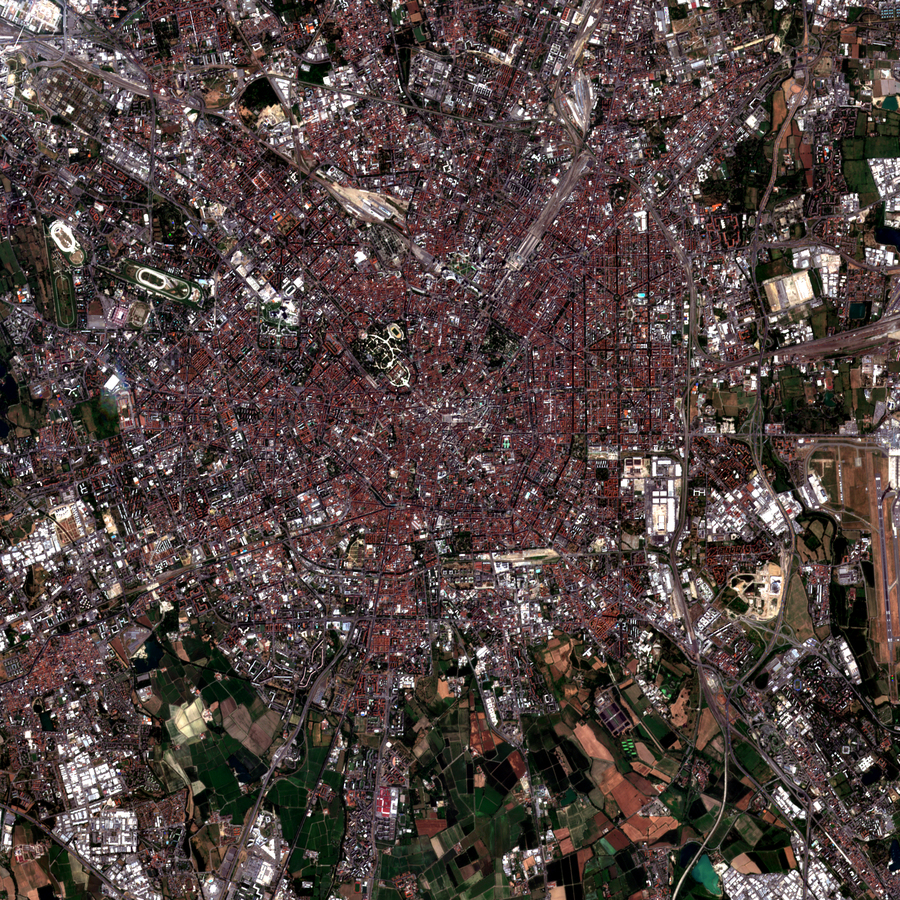

✓ Preview saved: data\downloads\S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217_preview\S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217_preview.png
✓ RGB GeoTIFF saved: data\downloads\S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217_preview\S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217_rgb.tif


In [26]:
# Create a true-color preview from the downloaded product ZIP (.SAFE/.zip)
from pathlib import Path

try:
    from cdse.processing import preview_product
except ImportError as e:
    print(f"⚠ Preview dependencies missing: {e}")
    print("  Run the previous cell to install: pillow rasterio")
    preview_product = None

# Use the downloaded file if present; otherwise, point to an existing local ZIP
safe_zip: Path | None
if 'path' in globals() and isinstance(path, Path) and path.exists():
    safe_zip = path
else:
    safe_zip = None
    print("⚠ No downloaded product found in variable 'path'. Run the download cell first.")

if safe_zip and preview_product:
    print(f"Generating RGB preview for: {safe_zip.name}")
    # Cropping to BBOX makes it faster and more relevant; set bbox=None for full-tile preview
    result = preview_product(
        safe_zip,
        bbox=BBOX,
        resolution=10,
        display=True,
        size=(900, 900),
    )
    print(f"✓ Preview saved: {result['preview_path']}")
    print(f"✓ RGB GeoTIFF saved: {result['tiff_path']}")

## 7. Product Properties

Explore all available product properties.

In [27]:
# Explore Product dataclass
if products:
    p = products[0]
    
    print(f"Product: {p.name}")
    print(f"=" * 60)
    print(f"ID:          {p.id}")
    print(f"Datetime:    {p.datetime}")
    print(f"Platform:    {p.platform}")
    print(f"Cloud cover: {p.cloud_cover}%")
    print(f"Size:        {p.size_mb or 'N/A'} MB")
    print(f"Tile ID:     {p.tile_id}")
    print(f"Geometry:    {p.geometry['type']}")
    
    print(f"\nAll properties ({len(p.properties)} keys):")
    for k, v in sorted(p.properties.items()):
        print(f"  {k}: {str(v)[:60]}{'...' if len(str(v)) > 60 else ''}")

Product: S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE
ID:          S2A_MSIL2A_20250626T101701_N0511_R065_T32TNR_20250626T142217.SAFE
Datetime:    2025-06-26 10:28:29.918000+00:00
Platform:    sentinel-2a
Cloud cover: 9.93%
Size:        N/A MB
Tile ID:     None
Geometry:    MultiPolygon

All properties (9 keys):
  constellation: sentinel-2
  datetime: 2025-06-26T10:28:29.918Z
  eo:cloud_cover: 9.93
  gsd: 10
  instruments: ['msi']
  platform: sentinel-2a
  proj:bbox: [499980.0, 4990200.0, 609780.0, 5100000.0]
  proj:epsg: 32632
  proj:geometry: {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties...


## 7b. Async client (optional)

Demonstrates the async API (requires `cdse-client[async]`).

In [28]:
# Set RUN_ASYNC=True if you want to execute this section
RUN_ASYNC = False

if RUN_ASYNC:
    import asyncio
    from cdse.async_client import CDSEClientAsync

    async def _run():
        async with CDSEClientAsync(output_dir=str(OUTPUT_DIR), max_concurrent=2) as aclient:
            aprods = await aclient.search(
                bbox=BBOX,
                start_date='2025-06-01',
                end_date='2025-06-30',
                collection='sentinel-2-l2a',
                cloud_cover_max=30,
                limit=2,
            )
            print(f"Async search returned: {len(aprods)}")
            # WARNING: downloads can be large
            # paths = await aclient.download_all(aprods)
            # print(paths)

    asyncio.run(_run())
else:
    print("Skipping async demo (set RUN_ASYNC=True to run)")

Skipping async demo (set RUN_ASYNC=True to run)


## 8. All Exports Summary

Verify all exported functions are accessible.

In [29]:
# Verify all public exports
import cdse

print(f"cdse-client v{cdse.__version__}")
print("=" * 60)

# Core classes
print("\n✓ Core classes:")
print(f"  CDSEClient: {cdse.CDSEClient}")
print(f"  Product: {cdse.Product}")
print(f"  OAuth2Auth: {cdse.OAuth2Auth}")
print(f"  Catalog: {cdse.Catalog}")
print(f"  Downloader: {cdse.Downloader}")

# Exceptions
print("\n✓ Exceptions:")
print(f"  CDSEError, AuthenticationError, CatalogError, DownloadError, ValidationError")

# Converters (v0.3.0)
print("\n✓ Converters (v0.3.0):")
print(f"  to_dataframe: {cdse.to_dataframe}")
print(f"  to_geojson: {cdse.to_geojson}")
print(f"  to_geodataframe: {cdse.to_geodataframe}")
print(f"  products_size: {cdse.products_size}")
print(f"  products_count: {cdse.products_count}")

# Geometry utilities
print("\n✓ Geometry utilities:")
print(f"  read_geojson, geojson_to_wkt, wkt_to_geojson, bbox_to_geojson, geojson_to_bbox, validate_geometry")

print("\n" + "=" * 60)
print("All tests completed!")

cdse-client v0.3.0

✓ Core classes:
  CDSEClient: <class 'cdse.client.CDSEClient'>
  Product: <class 'cdse.product.Product'>
  OAuth2Auth: <class 'cdse.auth.OAuth2Auth'>
  Catalog: <class 'cdse.catalog.Catalog'>
  Downloader: <class 'cdse.downloader.Downloader'>

✓ Exceptions:
  CDSEError, AuthenticationError, CatalogError, DownloadError, ValidationError

✓ Converters (v0.3.0):
  to_dataframe: <function to_dataframe at 0x00000250D8F65DA0>
  to_geojson: <function to_geojson at 0x00000250D8F65D00>
  to_geodataframe: <function to_geodataframe at 0x00000250D8F65E40>
  products_size: <function products_size at 0x00000250D8F65EE0>
  products_count: <function products_count at 0x00000250D8F65F80>

✓ Geometry utilities:
  read_geojson, geojson_to_wkt, wkt_to_geojson, bbox_to_geojson, geojson_to_bbox, validate_geometry

All tests completed!
